### Raw usage data

In [2]:
del df_raw

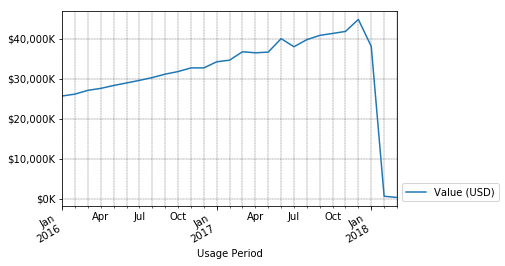

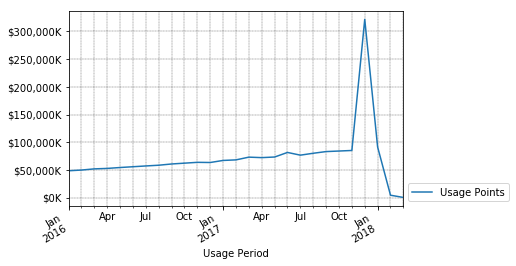

Index(['Aggregator', 'Aggregator Partner ID', 'Service Provider',
       'SP Partner ID', 'Contract No', 'Contract Size', 'Collected Point',
       'Base Price', 'Overage Price', 'Currency', 'GEO', 'Country',
       'Country Code', 'State', 'City', 'Postcode', 'Product Family',
       'Product', 'SKU', 'Units Utilised', 'Usage Points', 'Site Name',
       'Site Country', 'Site Postcode', 'Site Units Utilised',
       'Site Usage Points', 'Value', 'Value (USD)', 'Restricted Product',
       'Usage Period', 'Date Submitted', 'Collection Status',
       'Contract Usage Token', 'Contract Token', 'FX to USD', 'Was in Grace',
       'Partner Group Name', 'Partner Status', 'Product Group', 'NewQuarters',
       'Region', 'Avg VM Count', 'Avg Tenant Count', 'Product Category',
       'Contract Group'],
      dtype='object')


In [2]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
from matplotlib import pyplot as plt
import datetime
import numpy as np
from plot_helper import *

CSV_FILE = '../data/GlobalUsageReport.csv'

try:
    df_raw
except NameError:
    df_raw = pd.read_csv(CSV_FILE,encoding="ISO-8859-1",parse_dates=['Usage Period'])

df_raw.groupby('Usage Period')['Value (USD)'].sum().plot()
format_trend_chart()
plt.show()

df_raw.groupby('Usage Period')['Usage Points'].sum().plot()
format_trend_chart()
plt.show()


print(df_raw.columns)


### Active VCPP Rental Data

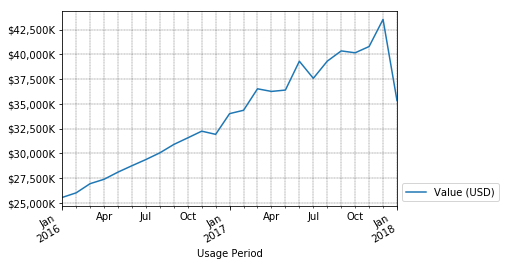

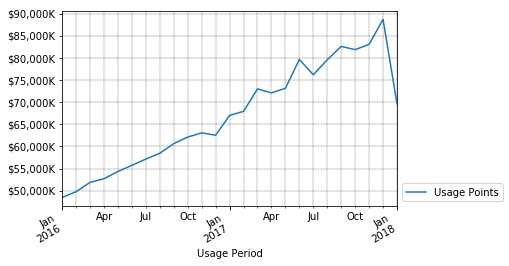

In [3]:
df_rental = df_raw[(df_raw['Product Family'] == 'Rental') &
                   ((df_raw['Collection Status'] == 'Closed') |
                    (df_raw['Collection Status'] == 'Pending Agg') |
                    (df_raw['Collection Status'] == 'Pending Vendor')                    
                   )]

df_rental.groupby('Usage Period')['Value (USD)'].sum().plot()
format_trend_chart()
plt.show()

df_rental.groupby('Usage Period')['Usage Points'].sum().plot()
format_trend_chart()
plt.show()


### Configure QUARTER_RANGE in defines.py

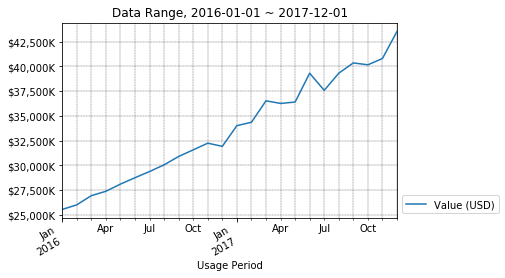

In [4]:
END_QUARTER = [
               datetime.date(2017,10,1),
               datetime.date(2017,11,1),
               datetime.date(2017,12,1)
               ]
YEAR_AGO_QUARTER = list(map(lambda x: x.replace(year=x.year-1),END_QUARTER))

START_QUARTER = [
                datetime.date(2016,1,1),
                datetime.date(2016,2,1),
                datetime.date(2016,3,1)
                ]

QUARTER_RANGE = (START_QUARTER,END_QUARTER)

START_MONTH = QUARTER_RANGE[0][0]
END_MONTH = QUARTER_RANGE[1][2]

df = df_rental[(df_rental['Usage Period']<=END_MONTH) & 
               (df_rental['Usage Period']>=START_MONTH)]

df.groupby('Usage Period')['Value (USD)'].sum().plot()
format_trend_chart()
plt.title("Data Range, {} ~ {}".format(START_MONTH,END_MONTH))
plt.show()

def df_usage_period(df,a,b):
    return df[(df['Usage Period']<=b) & (df['Usage Period']>=a)] 


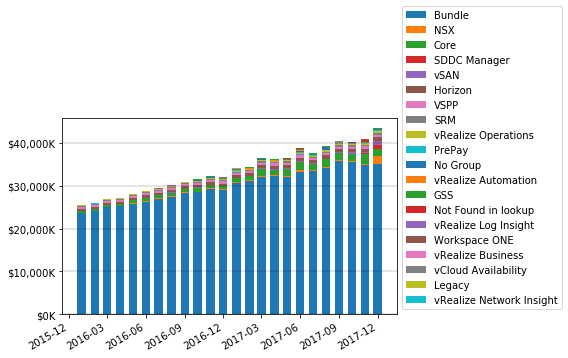

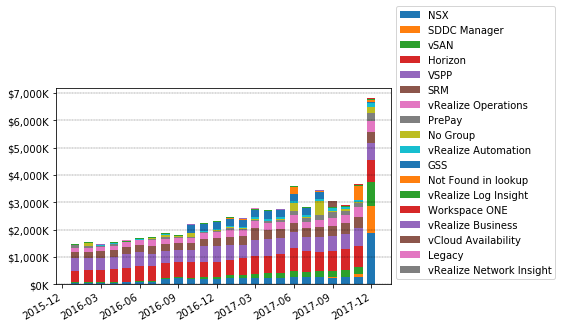

In [81]:
index = df.groupby('Usage Period')['Value (USD)'].sum().index

def plot_pg(df):
    sorted_pg = df_usage_period(df,END_QUARTER[2],END_QUARTER[2]).groupby('Product Group')['Value (USD)'].sum().sort_values(ascending=False)

    prev_bar = 0
    for pg in sorted_pg.index:
        by_period = df[df['Product Group']==pg].groupby('Usage Period')['Value (USD)'].sum()
    
        for up in index:
            if not up in by_period.keys():
                by_period.set_value(up,0.0)
                by_period = by_period.sort_index()
            
        plt.bar(by_period.index,by_period.values,width=20,label=pg,bottom=prev_bar)
        prev_bar += by_period.values
    
    format_trend_chart()
    plt.show()
    
plot_pg(df)
plot_pg(df[(df['Product Group']!='Bundle') & (df['Product Group']!='Core')])

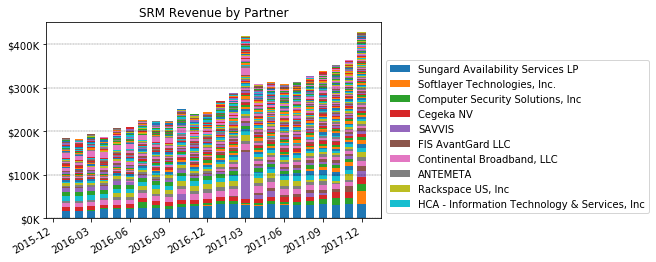

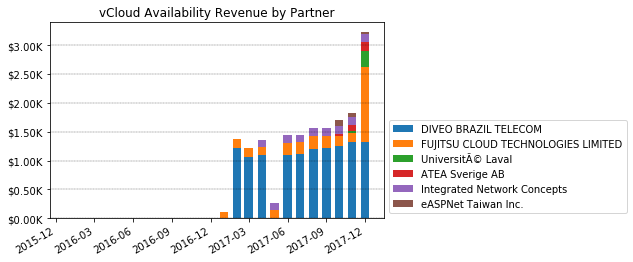

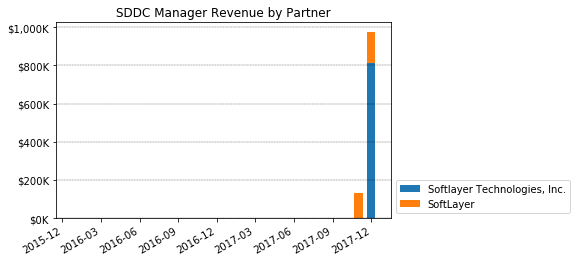

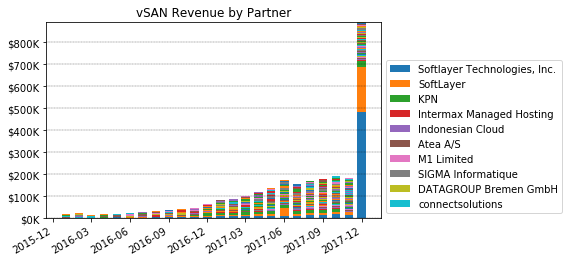

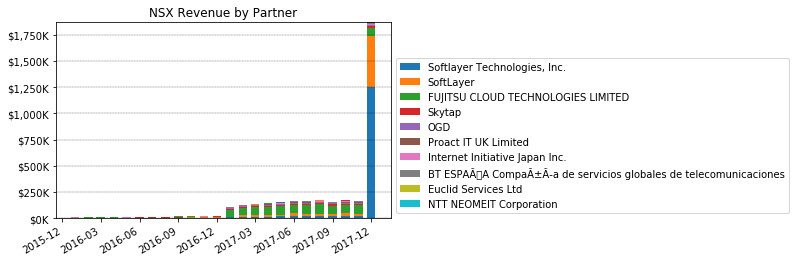

In [17]:
index = df.groupby('Usage Period')['Value (USD)'].sum().index

def plot_pg_sp(pg,yticketlabel='${:,.0f}K'):
    _df = df[df['Product Group']==pg]
    title = '{} Revenue by Partner'.format(pg)

    sorted_sp = df_usage_period(_df,END_QUARTER[2],END_QUARTER[2]).groupby('Service Provider')['Value (USD)'].sum().sort_values(ascending=False)

    prev_bar = 0
    for ii,sp in enumerate(sorted_sp.index):
        by_period = _df[_df['Service Provider']==sp].groupby('Usage Period')['Value (USD)'].sum()
    
        for up in index:
            if not up in by_period.keys():
                by_period.set_value(up,0.0)
                by_period = by_period.sort_index()
            
        plt.bar(by_period.index,by_period.values,width=20,label=sp if ii<10 else '',bottom=prev_bar)
        prev_bar += by_period.values
    
    format_trend_chart(yticklabel=yticketlabel)
    plt.title(title)
    plt.show()
    
plot_pg_sp('SRM')
plot_pg_sp('vCloud Availability',yticketlabel='${:,.2f}K')

plot_pg_sp('SDDC Manager')
plot_pg_sp('vSAN')
plot_pg_sp('NSX')

### Total VCPP Revenue & Parnter Cound Trend

YoY Partner Count Growth: +4%
YoY Quarter Revenue Growth : +30%


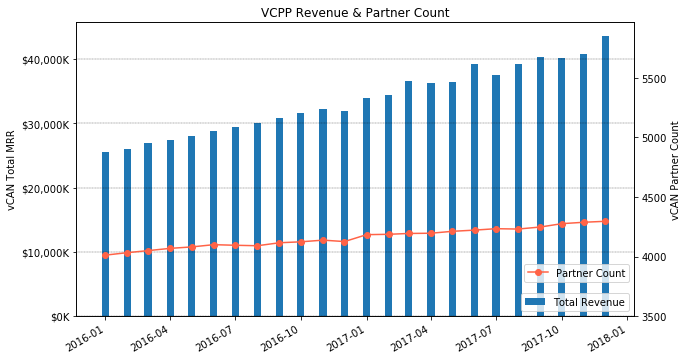

In [3]:
from functools import reduce

plt.close()
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()

rev = df.groupby('Usage Period')['Value (USD)'].sum()
ax1.bar(rev.index,rev.values,10,label='Total Revenue')

cnt = df.groupby('Usage Period')['Service Provider'].unique()
pcnts = list(map(lambda x: len(x), cnt.values))
ax2.plot(cnt.index,pcnts,'o-',c='tomato',label='Partner Count')
ax2.set_ylim(bottom=3500,top=3500*rev.values.max()/rev.values.min())
ax2.set_ylabel('vCAN Partner Count')
ax2.legend(loc="lower right", bbox_to_anchor=(1,0.1))
    
x0=len(cnt.loc[END_MONTH.replace(year=END_MONTH.year-1)])
x1=len(cnt.loc[END_MONTH])
print("YoY Partner Count Growth: +{:.0f}%".format((x1/x0-1)*100))

x0=reduce(lambda x,y:x+y,map(lambda x: rev.loc[x],map(lambda x: x.replace(year=x.year-1),END_QUARTER)))
x1=reduce(lambda x,y:x+y,map(lambda x: rev.loc[x],END_QUARTER))
VCPP_REV_GROWTH = x1/x0-1 
print("YoY Quarter Revenue Growth : +{:.0f}%".format(VCPP_REV_GROWTH*100))

ax1.yaxis.grid(which="major", color='black', linestyle='dashed', linewidth=.3)
ax1.set_yticklabels(['${:,.0f}K'.format(x/1000) for x in ax1.get_yticks()])
ax1.set_ylabel('vCAN Total MRR')
ax1.legend(loc="lower right", bbox_to_anchor=(1,0))

fig = plt.gcf()
fig.autofmt_xdate() 
plt.title("VCPP Revenue & Partner Count")
fig.set_size_inches(10,6)
plt.show()

### Price per Point Trend

### Showcase Partner Monthly Revenue Trend

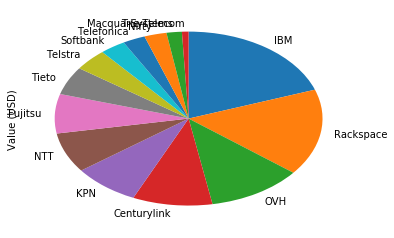

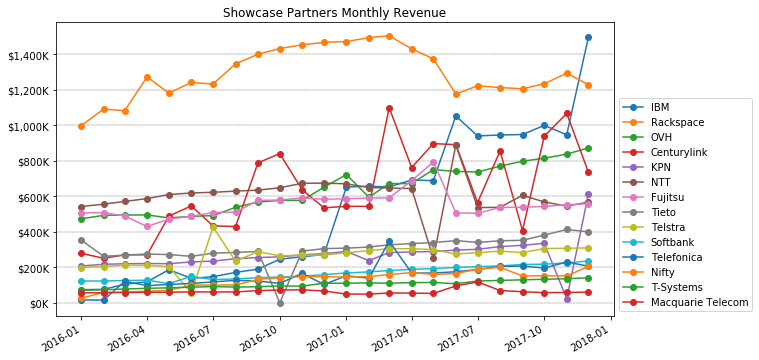

In [5]:
showcase_partners = df[(df['Usage Period'] == END_MONTH) &
                       (df['Partner Status'] == 'Showcase')].groupby('Partner Group Name')['Value (USD)'].sum().sort_values(ascending=False)

showcase_partners.plot.pie(startangle=90,counterclock=False)
plt.show()

for partner in showcase_partners.index:
    partner_rev = df[df['Partner Group Name'] == partner].groupby('Usage Period')['Value (USD)'].sum()
    plt.plot(partner_rev.index,partner_rev.values,'o-',label=partner)

format_trend_chart()

plt.title("Showcase Partners Monthly Revenue")
plt.gcf().set_size_inches(10,6)
plt.show()



### Showcase Partner Growth Trend

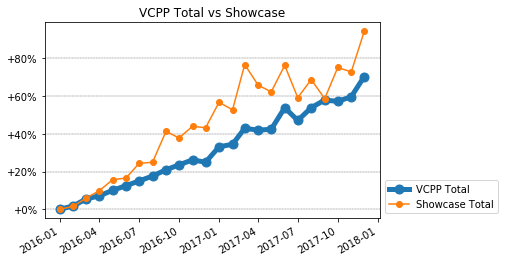

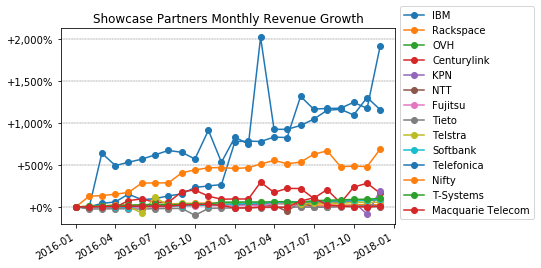

In [6]:
def plot_rev_trend(l,data,thick=False):
    if thick:
        plt.plot(data.index,(data.values/data.values[0]-1)*100,'o-',label=l,linewidth=5.0,markersize=9.0)
    else:
        plt.plot(data.index,(data.values/data.values[0]-1)*100,'o-',label=l)

def plot_partner(partner):
    plot_rev_trend(partner,df[df['Partner Group Name']==partner].groupby('Usage Period')['Value (USD)'].sum())

def format_chart(title):
    ax = format_trend_chart()
    ax.set_yticklabels(['+{:,.0f}%'.format(x) for x in ax.get_yticks()])
 #   ax.legend(loc="lower right", bbox_to_anchor=(1,0))
    plt.title(title)

plot_rev_trend('VCPP Total',df.groupby('Usage Period')['Value (USD)'].sum(),True)
plot_rev_trend('Showcase Total',df[df['Partner Status']=='Showcase'].groupby('Usage Period')['Value (USD)'].sum())
format_chart('VCPP Total vs Showcase')
plt.show()

for sp in showcase_partners.index:
    plot_partner(sp)
 
format_chart("Showcase Partners Monthly Revenue Growth")
plt.show()


Rackspace                                United States    (AMER) $   584,826 (18%)
IBM                                      United Kingdom   (EMEA) $ 3,189,787 (1,248%)
Centurylink                              United States    (AMER) $ 1,940,589 (242%)
OVH                                      France           (EMEA) $ 1,064,633 (73%)
NTT                                      Japan            (APAC) $    10,988 (1%)
Fujitsu                                  Japan            (APAC) $   150,394 (10%)
Tieto                                    Finland          (EMEA) $   310,598 (35%)
KPN                                      Netherlands      (EMEA) $   327,857 (51%)
Telstra                                  Australia        (APAC) $   307,049 (50%)
Softbank                                 Japan            (APAC) $   306,818 (82%)
Telefonica                               Spain            (EMEA) $   479,217 (311%)
Nifty                                    Japan            (APAC) $   363,647 (247%)

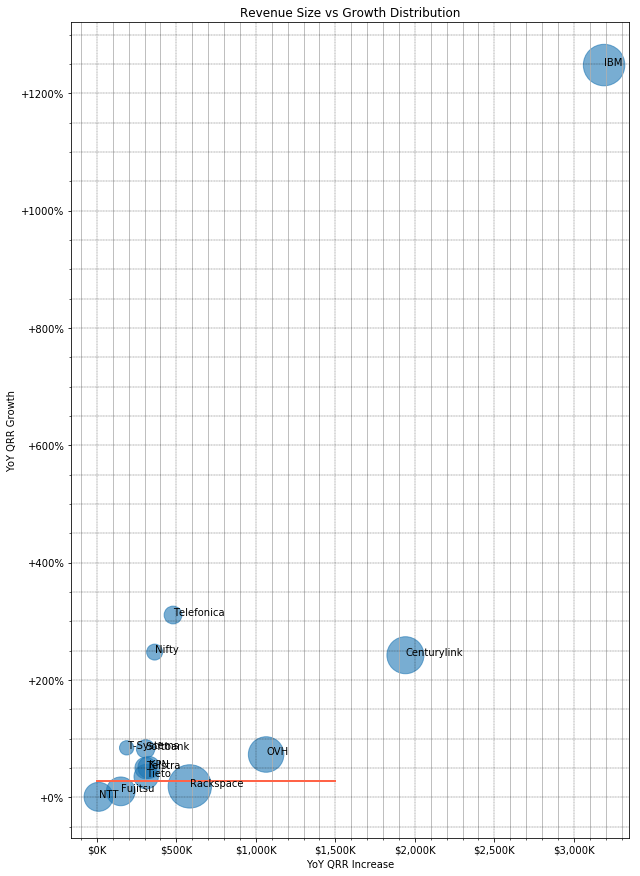

In [8]:
import size_vs_growth as sg
    
sg.plot(df[(df['Partner Status']=='Showcase')],
    {'type':['NO_SLICE'],
     'min_rev_growth':10000,
    'show_sp_name':0},group_key='Partner Group Name')

### VCPP Partners Revenue Distribution

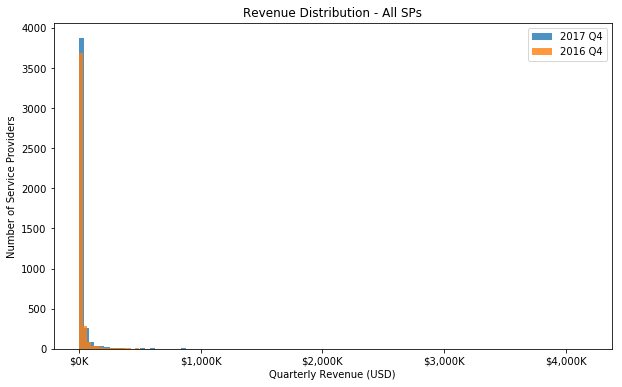

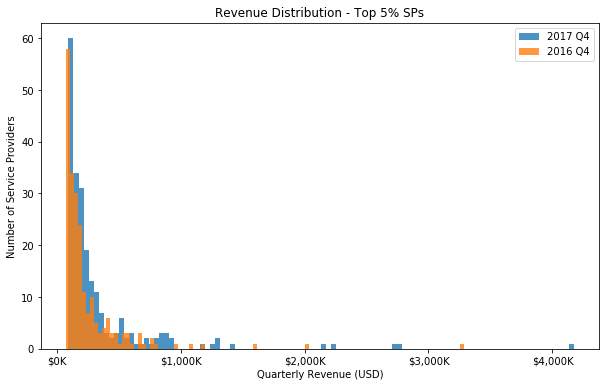

Total SP Count: 4386
Top 10 SPs Contribution: 16%
Softlayer Technologies, Inc.         4,170,429
Rackspace US, Inc                    2,765,411
SAVVIS                               2,742,297
OVH                                  2,219,209
SoftLayer                            2,152,686
Hewlett-Packard Enterprise Company   1,399,676
Canopy the Open Cloud Company        1,315,044
IBM                                  1,292,668
Internet Initiative Japan Inc.       1,257,213
Tieto Corporation                    1,192,637


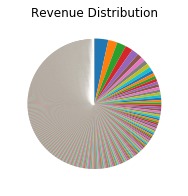

Total SP Count: 150
Top 10 SPs Contribution: 73%
Internet Initiative Japan Inc.       1,257,213
NTT Communications Corporation       951,097
Fujitsu Limited (Japan)              869,830
IDC Frontier Inc.                    510,839
FUJITSU CLOUD TECHNOLOGIES LIMITED   510,644
SoftBank Corp.                       385,005
NEC Corporation                      262,391
KDDI Corporation                     242,849
CTC/ITOCHU Techno-Solutions Corp     219,871
NS Solutions Corporation             200,217


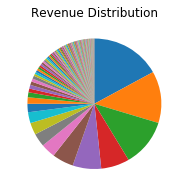

In [9]:
def df_quarter(df,Q):
    return df[(df['Usage Period'] >= Q[0]) & (df['Usage Period'] <= Q[2])]

def plot_hist(data_prev,data_last,cutoff,title):
    plt.hist(data_last[:int(len(data_last)*cutoff)],bins=100,alpha=.8,label='2017 Q4')
    plt.hist(data_prev[:int(len(data_last)*cutoff)],bins=100,alpha=.8,label='2016 Q4')

    plt.xlabel("Quarterly Revenue (USD)")
    plt.ylabel("Number of Service Providers")
    plt.title(title)
    ax = plt.gca()
    fig = plt.gcf()
    ax.set_xticklabels(['${:,.0f}K'.format(x/1000) for x in ax.get_xticks()])
    ax.legend(loc="upper right")
    fig.set_size_inches(10,6)
    plt.show()
    
df_last_q = df_quarter(df,END_QUARTER)
df_prev_q = df_quarter(df,YEAR_AGO_QUARTER)
data_last = df_last_q.groupby('Service Provider')['Value (USD)'].sum().sort_values(ascending=False)
data_prev = df_prev_q.groupby('Service Provider')['Value (USD)'].sum().sort_values(ascending=False)
    
plot_hist(data_prev,data_last,1.0,"Revenue Distribution - All SPs")
plot_hist(data_prev,data_last,0.05,"Revenue Distribution - Top 5% SPs")
    
def print_pie(df):
    total_last = df['Value (USD)'].sum()
    s_sp_val = df.groupby('Service Provider')['Value (USD)'].sum().sort_values(ascending=False)
    print("Total SP Count: {}".format(len(s_sp_val)))
    print("Top {} SPs Contribution: {:.0f}%".format(10,s_sp_val[:10].sum()/total_last*100))
    for sp,val in s_sp_val[:10].iteritems():
        print("{:36s} {:,.0f}".format(sp,val))
    
    plt.pie(s_sp_val.values,startangle=90,counterclock=False)
    plt.title('Revenue Distribution')
    plt.gcf().set_size_inches(3,3)
    plt.show()

print_pie(df_last_q)
print_pie(df_last_q[df_last_q['Country'] == 'Japan'])



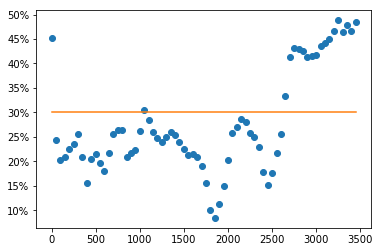

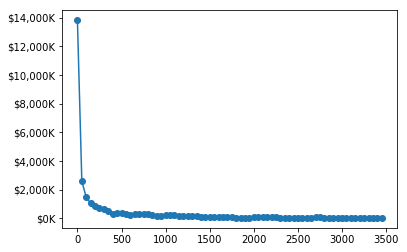

 1 Internet Initiative Japan Inc.                   6%
 2 NTT Communications Corporation                   -13%
 3 Fujitsu Limited (Japan)                          29%
 4 IDC Frontier Inc.                                17%
 5 FUJITSU CLOUD TECHNOLOGIES LIMITED               124%
 6 SoftBank Corp.                                   100%
 7 NEC Corporation                                  38%
 8 KDDI Corporation                                 55%
 9 CTC/ITOCHU Techno-Solutions Corp                 49%
10 NS Solutions Corporation                         46%
11 SCSK Corporation                                 37%
12 I-NET CORP.                                      8%
13 FreeBit Co.,Ltd.                                 7%
14 Uniadex ltd.                                     -2%
15 Hewlett-Packard Enterprise Japan Ltd.            5%
16 INTEC Inc.                                       30%
17 Japan Information Processing Service Co.,Ltd     22%
18 NTT SMARTCONNECT Corporation                  

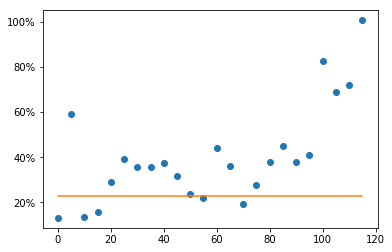

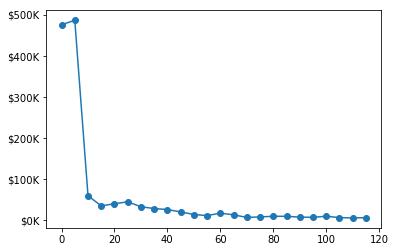

In [10]:
def build_rank_df(df,step=100,print_sp=range(0)):
    s_last_sp_rev = df_quarter(df,END_QUARTER).groupby('Service Provider')['Value (USD)'].sum().sort_values(ascending=False)
    s_prev_sp_rev = df_quarter(df,YEAR_AGO_QUARTER).groupby('Service Provider')['Value (USD)'].sum().sort_values(ascending=False)

    df_rank = pd.DataFrame(columns=['rank_start','rank_stop','rev_prev','rev_last','increase_rate','increase_value'])

    for r in range(0,len(s_last_sp_rev),step):
        start, stop = r, r+step
        last = s_last_sp_rev[start:stop].sum()
        prev = s_prev_sp_rev[start:stop].sum()
        growth_rate = (last/prev-1.0)*100
        
        if prev <= step*1000:
            break
        df_rank.loc[start] = [start,stop,prev,last,growth_rate,last-prev]

        for r in range(r,r+step):
            if ((print_sp.start <= r) and (r < print_sp.stop)):
                growth = (s_last_sp_rev[r]/s_prev_sp_rev[r]-1)*100
                print('{:2d} {:48s} {:.0f}%'.format(r+1,s_last_sp_rev.index[r],growth))
            
    return df_rank

def plot_rank_df(df_rank):
    total_growth_rate = (df_rank.rev_last.sum()/df_rank.rev_prev.sum()-1)*100
    plt.plot(df_rank.index,df_rank.increase_rate,'o')
    plt.plot(df_rank.index,np.ones_like(df_rank.index)*total_growth_rate,'-')    
    ax = plt.gca()
    ax.set_yticklabels(['{:.0f}%'.format(y) for y in ax.get_yticks()])
    plt.show()

    plt.plot(df_rank.index,df_rank.increase_value,'o-')
    ax = plt.gca()
    ax.set_yticklabels(['${:,.0f}K'.format(y/1000) for y in ax.get_yticks()])
    plt.show()

plot_rank_df(build_rank_df(df,50))
plot_rank_df(build_rank_df(df[df['Country'] == 'Japan'],5,range(0,20)))


### Showcase Partner - Group Companies Revenue Trend

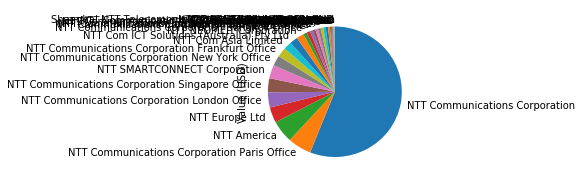

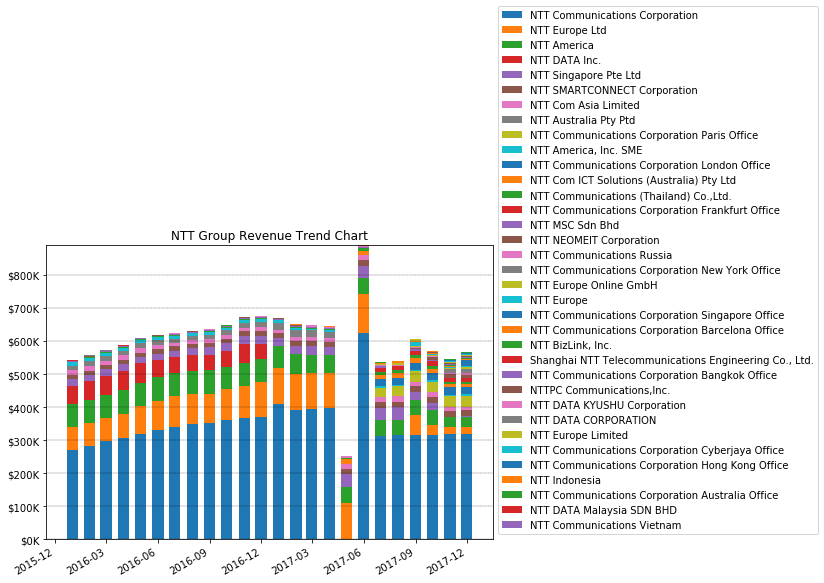

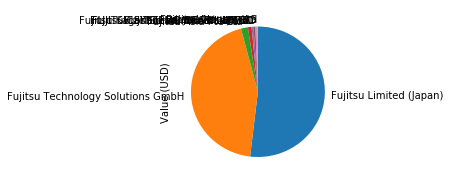

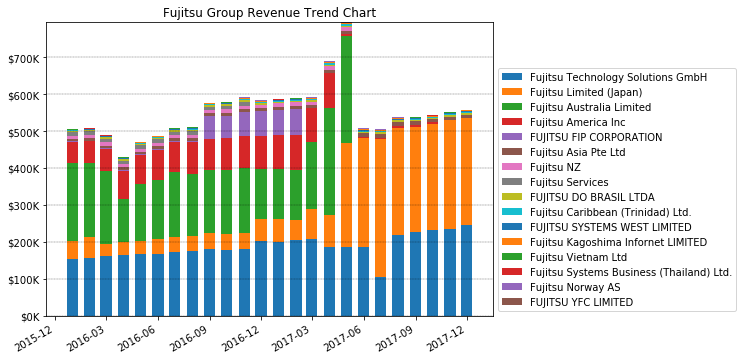

In [11]:
def partner_rev_trend(group,key='Value (USD)'):
    sp_group = df[df['Partner Group Name'] == group]

    # sort by revenue size at the last month
    sp_lm = sp_group[sp_group['Usage Period'] == END_MONTH].groupby('Service Provider')[key].sum().sort_values(ascending=False)
    
    sp_lm.plot.pie(startangle=90,counterclock=False)
    plt.gcf().set_size_inches(3,3)
    plt.show() 
    
#    sp_group = df[df['Partner Group Name'] == group]
    sp_sorted = sp_group.groupby('Service Provider')[key].sum().sort_values(ascending=False)

    # get the series of usage period
    index = sp_group.groupby('Usage Period')[key].sum().index
    
    prev_bar = 0
    for sp in sp_sorted.index:
        rev_by_period = df[df['Service Provider'] == sp].groupby('Usage Period')[key].sum() 
        for up in index:
            if not up in rev_by_period.keys():
                rev_by_period.set_value(up,0.0)
        rev_by_period = rev_by_period.sort_index()
 
        plt.bar(rev_by_period.index,rev_by_period.values,width=20,label=sp,bottom=prev_bar)
        prev_bar += rev_by_period.values
        
    format_trend_chart()

    plt.title('{} Group Revenue Trend Chart'.format(group))
    plt.gcf().set_size_inches(8,6)
    plt.show()
    
partner_rev_trend('NTT')
partner_rev_trend('Fujitsu')


### Revenue Size vs Growth

Softlayer Technologies, Inc.             United States    (AMER) $ 4,022,272 (2,715%)
Rackspace US, Inc                        United States    (AMER) $   524,254 (23%)
SAVVIS                                   United States    (AMER) $ 1,940,589 (242%)
OVH                                      France           (EMEA) $   914,364 (70%)
Hewlett-Packard Enterprise Company       United States    (AMER) $ 1,053,026 (304%)
Canopy the Open Cloud Company            United Kingdom   (EMEA) $ 1,196,351 (1,008%)
IBM                                      United States    (AMER) $ 1,069,586 (479%)
Virtustream                              United States    (AMER) $   583,850 (201%)
Fujitsu Limited (Japan)                  Japan            (APAC) $   729,172 (518%)


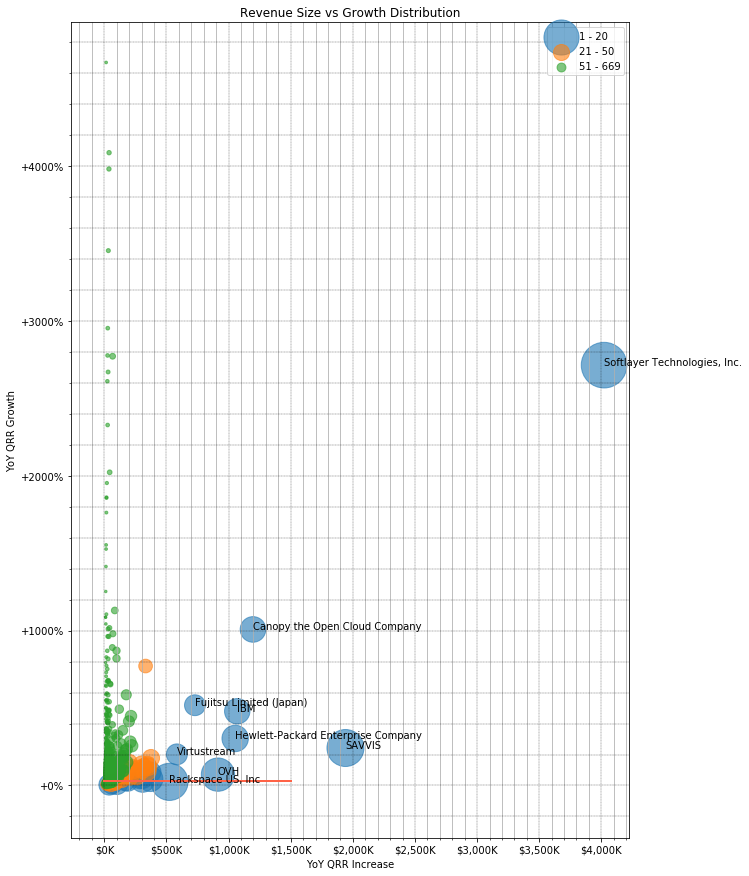

Rackspace US, Inc                        United States    (AMER) $   524,254 (23%)
SAVVIS                                   United States    (AMER) $ 1,940,589 (242%)
Hewlett-Packard Enterprise Company       United States    (AMER) $ 1,053,026 (304%)
IBM                                      United States    (AMER) $ 1,069,586 (479%)
Virtustream                              United States    (AMER) $   583,850 (201%)
Fujitsu Limited (Japan)                  Japan            (APAC) $   729,172 (518%)
Canopy the Open Cloud Company            United Kingdom   (EMEA) $ 1,196,351 (1,008%)
Canopy the Open Cloud Company            United Kingdom   (EMEA) $ 1,196,351 (1,008%)


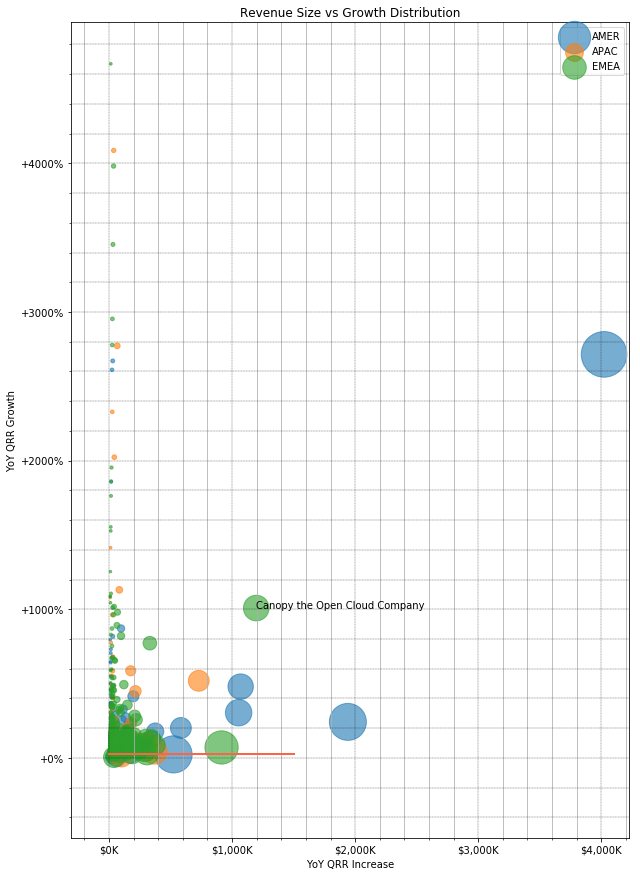

Internet Initiative Japan Inc.           Japan            (APAC) $   370,395 (42%)
NTT Communications Corporation           Japan            (APAC) $   100,874 (12%)
Fujitsu Limited (Japan)                  Japan            (APAC) $   729,172 (518%)
SoftBank Corp.                           Japan            (APAC) $   214,544 (126%)
NEC Corporation                          Japan            (APAC) $   214,523 (448%)
KDDI Corporation                         Japan            (APAC) $   124,926 (106%)
NS Solutions Corporation                 Japan            (APAC) $   132,893 (197%)


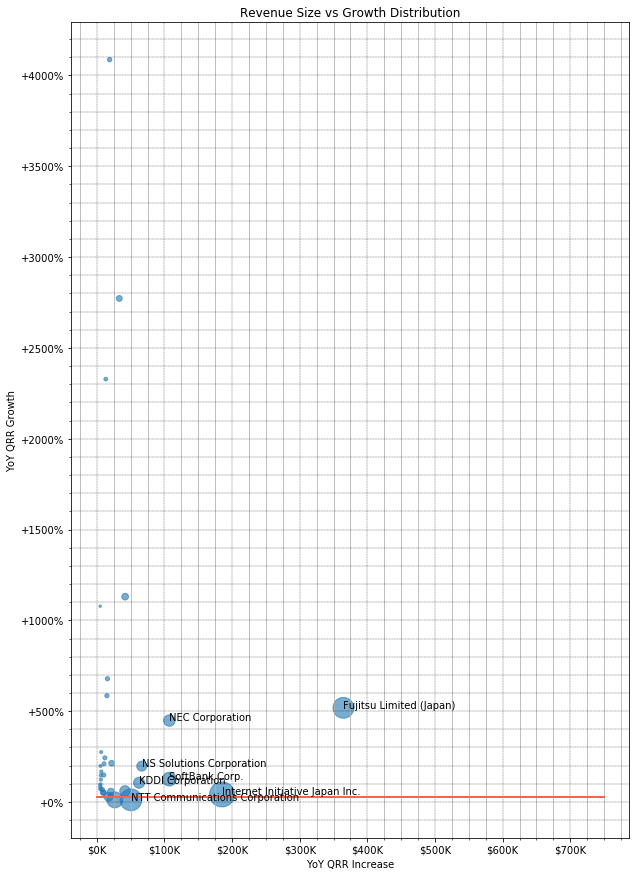

In [12]:
import size_vs_growth as sg

sg.plot(df,
     {'type':['GEO','RANK'],
      'time_frame': 'LAST_12',
      'min_rev_growth':10000,
      'show_sp_name':500000})
    
sg.plot(df[(df['Country']=='Japan')],
    {'type':['NO_SLICE'],
     'time_frame': 'LAST_12',     
     'min_rev_growth':10000,
    'show_sp_name':100000})

In [13]:
def print_mom_growth(s):
    for i,d in enumerate((s/s.shift(1)-1)*100):
        print('---') if s.index[i].month % 3 == 2 else None
        print('{:%b %Y} {:6.2f}%'.format(s.index[i],d))

def s_usage_point(df,g='ALL'):
    if g != 'ALL':
        df = df[df['Partner Group Name']==g]
    return df.groupby('Usage Period')['Usage Points'].sum()

# print_mom_growth(s_usage_point(df))
print('NTT')
print_mom_growth(s_usage_point(df,g='NTT'))
print('Fujitsu')
print_mom_growth(s_usage_point(df,g='Fujitsu'))




NTT
Jan 2016    nan%
---
Feb 2016   2.26%
Mar 2016   2.63%
Apr 2016   2.86%
---
May 2016   3.71%
Jun 2016   1.32%
Jul 2016   0.34%
---
Aug 2016   0.90%
Sep 2016   1.11%
Oct 2016   1.90%
---
Nov 2016   4.14%
Dec 2016  -0.06%
Jan 2017  -0.79%
---
Feb 2017  -3.12%
Mar 2017  -0.54%
Apr 2017  -0.68%
---
May 2017 -57.38%
Jun 2017 279.50%
Jul 2017 -38.77%
---
Aug 2017   0.41%
Sep 2017  12.89%
Oct 2017  -6.99%
---
Nov 2017  -4.41%
Dec 2017   4.08%
Fujitsu
Jan 2016    nan%
---
Feb 2016   0.61%
Mar 2016  -3.25%
Apr 2016 -10.59%
---
May 2016   8.66%
Jun 2016   3.01%
Jul 2016   4.19%
---
Aug 2016   0.58%
Sep 2016  11.83%
Oct 2016   0.21%
---
Nov 2016   2.00%
Dec 2016  -0.53%
Jan 2017   0.47%
---
Feb 2017   1.22%
Mar 2017   3.02%
Apr 2017  13.30%
---
May 2017  27.81%
Jun 2017 -34.84%
Jul 2017  12.20%
---
Aug 2017   6.93%
Sep 2017   0.06%
Oct 2017   0.74%
---
Nov 2017   2.13%
Dec 2017   0.76%


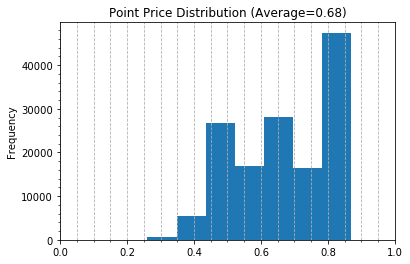

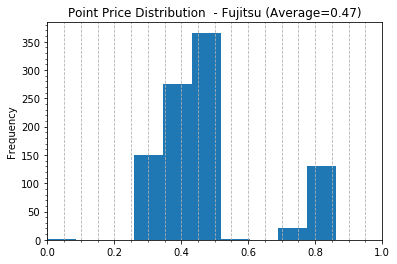

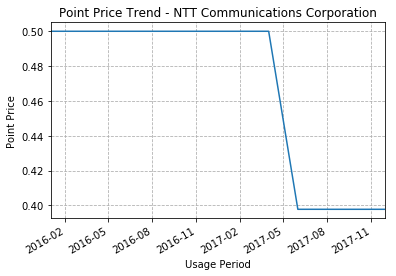

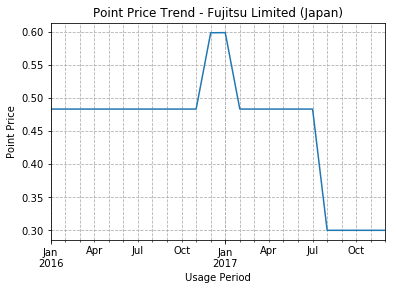

In [4]:
def plot_dist(d,caption=''):
    pp = d['Value (USD)']/d['Usage Points']

    pp.plot.hist(bins=10)
    plt.minorticks_on()
    plt.gca().xaxis.grid(True, which='both',linestyle='dashed')
    plt.xlim([0,1.0])
    plt.title("Point Price Distribution {}(Average={:.2f})".format(caption,pp.mean()))
    plt.show()

_df = df[df['Usage Points'] > 0]
_df_fujitsu = _df[_df['Partner Group Name']=='Fujitsu'].copy()

plot_dist(_df)
plot_dist(_df_fujitsu,caption=' - Fujitsu ')

def point_price_trend(sp):
    _df_sp = _df[_df['Service Provider']==sp].copy()
#    _df_sp = _df[_df['Partner Group Name']==sp].copy()
    _df_sp.loc[:,'Point Price'] = pd.Series(_df_sp['Value (USD)']/_df_sp['Usage Points'],index=_df_sp.index)

    _df_sp.groupby('Usage Period')['Point Price'].max().plot()
    plt.ylabel('Point Price')
    plt.gca().xaxis.grid(True, which='both',linestyle='dashed')
    plt.gca().yaxis.grid(True, which='both',linestyle='dashed')
    plt.title('Point Price Trend - {}'.format(sp))
    plt.show()
    

point_price_trend('NTT Communications Corporation')
point_price_trend('Fujitsu Limited (Japan)')





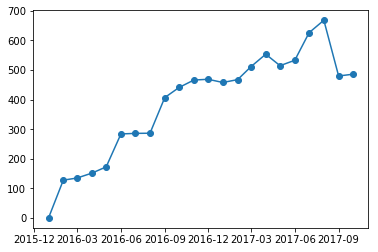

In [222]:
s_nifty = df[(df['Service Provider'].str.match(r'.*FUJITSU CLOUD.*')) | (df['Service Provider'].str.match(r'.*NIFTY.*'))].groupby('Usage Period')['Value (USD)'].sum()

start = s_nifty.values[0]

plt.plot(s_nifty.index,(s_nifty.values/start-1)*100,'o-',label='Nifty Revenue')
#format_trend_chart()
plt.show()

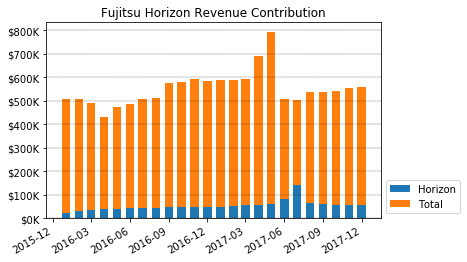

In [7]:
df_f = df[df['Partner Group Name']=='Fujitsu']
df_f_h = df_f[df_f['Product'].str.match(r'.*Horizon.*')]

total = df_f.groupby('Usage Period')['Value (USD)'].sum()
horizon = df_f_h.groupby('Usage Period')['Value (USD)'].sum()

plt.bar(total.index,horizon.values,20,label='Horizon')
plt.bar(total.index,total.values-horizon.values,20,label='Total',bottom=horizon.values)

format_trend_chart()
plt.title('Fujitsu Horizon Revenue Contribution')
plt.show()
    
#(df['Product Group']=='Horizon']
